# NLP on Review Data

This notebook consists of code that will:

1. Import Business Information and Review Data (and subselect data if needed).
2. Create Restaurant and Review objects
3. Condition the Review Data - clean, remove stopwords, tokenize, perform phrase analysis
4. Visualize sentiment by star rating and over time for a business.
5. Perform TFIDF Analysis to get important words/phrases for a business.
6. Perform Word Embedding to further gain insights about business reviews. - visualize embedding space

# Import Python Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import nltk
import re
import gensim
from gensim.summarization import keywords
from gensim.models import Word2Vec

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

import string
import time

from gensim.models import Phrases
from gensim.models.phrases import Phraser

## Graphing Libraries
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from textblob import TextBlob

# Import My Functions and Classes

In [2]:
from data_queries import business_info_df, reviews_df
from data_queries import get_businesses_by_category
from data_queries import get_reviews_by_category 
from data_queries import get_businesses_by_name
from data_queries import get_reviews_for_businesses
from data_queries import get_subset_list

from data_classes import Review, Restaurant
#from data_classes import clean_text

from data_analysis import get_idf, get_tfidf_scores, dummy_function
from data_analysis import get_polarity_over_time, display_polarity_over_time
from data_analysis import tsne_plot_words

# Downselect Categories and Businesses - Subset

If you want to reduce the amount of data being used, and to reduce file outputs for tableau / github. Downselect the data using the parameters below.

Set boolean variable below:

In [3]:
subset = True #Set TRUE or FALSE
tableau = False

#Set parameters below if using a subset of Data
#tableau 9, 100, 1500
#subset for predictions 5, 40, 1500
min_businesses_in_category = 5  #Minimum number of businesses in a category in order to include category
min_reviews_per_business = 40  #Minimum number of reviews for a business in order to include the business
min_reviews_per_category = 1500  #Minimum number of reviews in a category in order to include the category

if subset or tableau:
    biz_list, category_list = get_subset_list(min_businesses_in_category, 
                                              min_reviews_per_business, 
                                              min_reviews_per_category)

Mexican               15 places,  2235 reviews
Diners                20 places,  1682 reviews
Asian Fusion          18 places,  1625 reviews
American Traditional  82 places,  8876 reviews
Italian               57 places,  5364 reviews
Bars                  81 places,  9932 reviews
Salad                 28 places,  2835 reviews
Burgers               34 places,  4235 reviews
Mediterranean         12 places,  1514 reviews
Sushi Bars            29 places,  3148 reviews
Seafood               27 places,  3609 reviews
Barbeque              10 places,  1631 reviews
Pizza                 51 places,  4503 reviews
Japanese              25 places,  2822 reviews
Steakhouses           15 places,  2068 reviews
Sandwiches            45 places,  4225 reviews
Thai                  14 places,  1626 reviews
Indian                17 places,  1714 reviews
American New          43 places,  5410 reviews
Cafes                 13 places,  1846 reviews
Pubs                  36 places,  4049 reviews
Breakfast & B

### Update dataframe if using subset

In [4]:
if subset or tableau:
    print("Original Number of Reviews:", len(reviews_df))
    indices_to_keep = get_reviews_for_businesses(biz_list).index
    indices_to_drop = [index_value for index_value in reviews_df.index if index_value not in indices_to_keep]
    reviews_df.drop(index=indices_to_drop, inplace=True)
    print("New Number of Reviews:", len(reviews_df), "\n")
    
    print("Original Number of Businesses:", len(business_info_df))
    indices_to_keep = business_info_df[[biz in biz_list for biz in business_info_df.biz_id]].index
    indices_to_drop = [index_value for index_value in business_info_df.index if index_value not in indices_to_keep]
    business_info_df.drop(index=indices_to_drop, inplace=True)
    print("New Number of Businesses:", len(business_info_df))
    
    #Subset of data to make files smaller for github or tableau
    if subset:
        business_info_df.to_csv('csv_files/business_info.csv',index=False)
        reviews_df.to_csv('csv_files/reviews.csv',index=False)
    
    if tableau:
        business_info_df.drop(columns=['image_shown','num_reviews','url']).to_csv('csv_files/tableau_business_info.csv',index=False)
        #reviews_df.drop(columns=['pic_count','pic_urls','review','user_id']).to_csv('csv_files/tableau_reviews.csv',index=False)

Original Number of Reviews: 59274
New Number of Reviews: 43603 

Original Number of Businesses: 1081
New Number of Businesses: 395


# Initialize Restaurant Objects & Review Objects

Objects are **Restaurant** and **Review** classes defined in `data_classes.py`.

In [5]:
restaurants = []

for idx in business_info_df.index:
    
    #Get Relevant Restaurant Information
    name = business_info_df.name[idx]
    address = business_info_df.address[idx]
    categories = business_info_df.category[idx]
    price_range = business_info_df.price_range[idx]
    star_rating = business_info_df.star_rating[idx]
    business_index = business_info_df.biz_id[idx]
    
    #Create Restaurant Object
    restaurants.append(Restaurant(name, business_index, address, categories, price_range, star_rating))

In [6]:
reviews = []
for idx in reviews_df.index:
    text = reviews_df.review[idx] 
    date = reviews_df.date[idx]
    star_rating = reviews_df.star_rating[idx]
    reviews.append(Review(text, date, star_rating))

In [7]:
if tableau:
    category_biz_link = []
    for category in category_list:
        for restaurant in restaurants:
            if restaurant.is_in_category(category):
                category_biz_link.append({'business_idx': restaurant.biz_id, 'category_name': category})
    pd.DataFrame(category_biz_link).to_csv('csv_files/tableau_categories.csv', index=False)

# Data Conditioning
Cleaning, Stopword removal, Tokenization, Polarity

### Clean, Tokenize, Assign Polarity

In [8]:
tokenizer = nltk.tokenize.TweetTokenizer(preserve_case=False).tokenize

In [9]:
print("Cleaning, Tokenizing, Assigning Polarity:", end=' ')
start = time.time()

for review in reviews:
    review.clean_text()
    review.assign_polarity()
    review.tokenize(tokenizer)
    
end = time.time()
print(time.strftime('%H:%M:%S', time.gmtime(end-start)))

Cleaning, Tokenizing, Assigning Polarity: 00:01:27


In [10]:
reviews_df['polarity'] = [review.polarity for review in reviews]

### Polarity versus star rating

43603 reviews used


/Users/dennistrimarchi/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



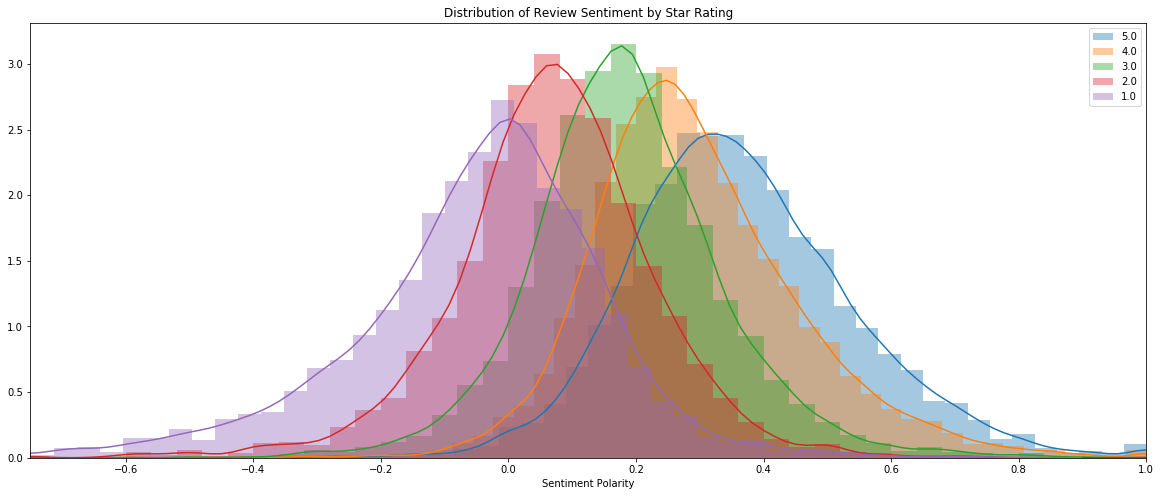

In [11]:
search_term = ''
selected_reviews = get_reviews_by_category(search_term)
print(len(selected_reviews), "reviews used")

ratings = sorted(selected_reviews.star_rating.unique(),reverse=True)
plt.figure(figsize=(20,8))
for rating in ratings:
    sns.distplot(selected_reviews.polarity[selected_reviews.star_rating==rating], kde=True, label=rating)
plt.legend()
plt.xlim((-0.75,1))
plt.xlabel('Sentiment Polarity');
plt.title('Distribution of Review Sentiment by Star Rating');

### Phrasing of Reviews

I did not want phrases to go from the end of a sentence to the beginning of another sentence. Therefore, I treat each sentence as a separate item for phrasing.

In [12]:
def fit_phraser(sentences, min_count=5, threshold=6, scoring='default'):
#def fit_phraser(sentences, min_count=5, threshold=0.35, scoring='npmi'):
    """
    This function returns a gensim bigram phraser. The phraser is fit to the sentences passed in 
    and passes the min_count, threshold, and scoring parameters to Phrases in gensim.models.
    """
    bigram = Phrases(sentences=sentences, min_count=min_count, threshold=threshold, scoring=scoring)
    return Phraser(bigram)

In [13]:
#stopwords = nltk.corpus.stopwords.words('english')

In [14]:
#for review in reviews:
    #review.remove_stopwords(stopwords)
    #review.drop_short_words(2)
    #review.drop_short_sentences(1)

**Bigrams**

In [15]:
#GET ALL SENTENCES, THEN FIT A PHRASER
all_sentences = []
for review in reviews:
    all_sentences.extend(review.text)
print(len(all_sentences), "sentences across all reviews.")

339974 sentences across all reviews.


In [16]:
print("Bigram Phrasing:", end=' ')
start = time.time()

bigram_phraser = fit_phraser(all_sentences)
[review.apply_phraser(bigram_phraser) for review in reviews]
all_sentences = [bigram_phraser[sentence] for sentence in all_sentences]

end = time.time()
print(time.strftime('%H:%M:%S', time.gmtime(end-start)))

Bigram Phrasing: 00:01:12


**Trigrams**

In [17]:
print("Trigram Phrasing:", end=' ')
start = time.time()

trigram_phraser = fit_phraser(all_sentences)
[review.apply_phraser(trigram_phraser) for review in reviews]

end = time.time()
print(time.strftime('%H:%M:%S', time.gmtime(end-start)))

Trigram Phrasing: 00:00:58


In [18]:
reviews_df['review_cleaned'] = [review.get_pretty_review() for review in reviews]

### Remove Stopwords

First remove NLTK Corpus Stopwords

In [19]:
stopwords = nltk.corpus.stopwords.words('english')

In [20]:
for review in reviews:
    review.remove_stopwords(stopwords)

See other Common words

In [21]:
tokenized_full_reviews = [review.get_all_tokens() for review in reviews]

In [22]:
def get_word_counts(tokenized_sentences):
    reviews_w2v_model = Word2Vec(tokenized_sentences,size=100,window=5,min_count=1,workers=4)
    words = []
    counts = []
    for word, vocab_obj in reviews_w2v_model.wv.vocab.items():
        words.append(word)
        counts.append(vocab_obj.count)
    df = pd.DataFrame(data=counts,index=words, columns=['word_counts'])
    return df.sort_values(by='word_counts', ascending=False)

Top 20 by word count

In [23]:
top_20_count = get_word_counts(tokenized_full_reviews)[0:20]
print(list(top_20_count.index))

['food', 'good', 'great', 'service', 'place', 'one', 'ordered', 'get', 'like', 'also', 'really', 'go', 'menu', 'delicious', 'this_place', 'order', 'got', 'restaurant', 'us', 'nice']


Top 20 by IDF weight

In [24]:
top_20_idf = get_idf(tokenized_full_reviews, tokenized=True, ngram_range=(1,1))[0:20]
print(list(top_20_idf.index))

['food', 'good', 'great', 'service', 'place', 'one', 'get', 'like', 'also', 'ordered', 'go', 'delicious', 'really', 'this_place', 'menu', 'order', 'nice', 'restaurant', 'got', 'best']


In [25]:
additional_stopwords = list(set(list(top_20_count.index) + list(top_20_idf.index)))

In [26]:
for review in reviews:
    review.remove_stopwords(additional_stopwords)
    review.drop_short_words(2)
    review.drop_short_sentences(1)

### Write tokenized reviews to csv file
Tokenized reviews are needed for machine learning models in rating prediction notebook `Project_Predict_Ratings.ipynb`.

In [27]:
#Add tokenized reviews to csv file for rating predictions notebook
reviews_df['review_tokenized'] = [review.get_all_tokens() for review in reviews]
if subset:
    reviews_df.drop(columns=['review_cleaned']).to_csv('csv_files/reviews.csv',index=False)

In [28]:
my_phrases = []
for review in reviews_df.review_tokenized:
    for word in review:
        if word.count('_')>=2:
            my_phrases.append(word)
            
my_phrases = list(set(my_phrases))

### Add Cleaned and Tokenized Review objects to Restaurant obects

In [29]:
reviews_df['review_obj'] = reviews

In [30]:
for restaurant in restaurants:
    selected_reviews = list(reviews_df.review_obj[reviews_df.business_index==restaurant.biz_id])
    restaurant.set_reviews(selected_reviews)

# See Restaurant Sentiment over Time

In [31]:
def get_restaurants(search_term):
    search_results = [rest for rest in restaurants if bool(re.search(search_term, rest.biz_id.lower()))]
    display([rest.biz_id for rest in search_results])
    return search_results

In [32]:
search_term = 'wolffs'

search_results = get_restaurants(search_term)

['Berben And Wolffs Albany',
 'Wolffs Biergarten Albany',
 'Wolffs Biergarten Schenectady']

/Users/dennistrimarchi/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



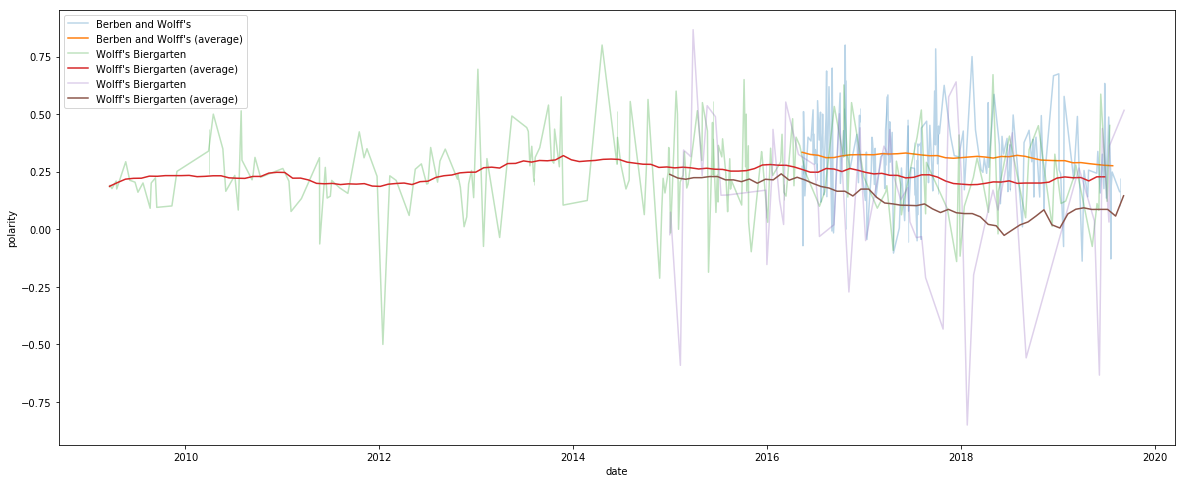

In [33]:
display_polarity_over_time(search_results)

# TF/IDF Analysis

Compare a restaurants reviews to other restaurant reviews in the same categories.
Break down by star rating for each comparison.

In [34]:
#Declare a TfidfVectorizer to be used for TF/IDF analysis
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1),
                                   tokenizer=dummy_function,
                                   preprocessor=dummy_function,
                                   token_pattern=None)

In [35]:
n = 50 #Number of key words to store

tfidf_keywords = []

print("TFIDF for Each Restaurant within category:", end=' ')
start = time.time()

#Loop through restaurants
for restaurant in restaurants:

    #Get Categories that restaurant is a part of
    category_list = restaurant.categories
    doc_lists = {5.0:[],4.0:[],3.0:[],2.0:[],1.0:[]}
    
    #Loop through restaurants and determine those that are part of the same categories
    for rest_2 in restaurants:
        if any([rest_2.is_in_category(cat) for cat in category_list]):
            
            #Populate doc lists for each star rating
            for rating in [1,2,3,4,5]:
                doc_lists[rating].append(rest_2.get_document(star_rating=rating))
                
    #Now have doc lists for every star rating within a restaurant's categories
    
    for rating in [1,2,3,4,5]:
        #Fit TFIDF Vectorizer for docs in each star rating
        tfidf_vectorizer.fit(doc_lists[rating])
        
        #Transform original docs for restaurant
        rest_document = restaurant.get_document(star_rating=rating)
        if rest_document:
            results = get_tfidf_scores(tfidf_vectorizer, rest_document)[0:n]
            restaurant.set_keywords(rating, results.index, results.score)
    
    #Get data into a list so that it can be saved to a csv file
    tfidf_keywords.extend(restaurant.get_keywords())
    
end = time.time()
print(time.strftime('%H:%M:%S', time.gmtime(end-start)))

TFIDF for Each Restaurant within category: 00:02:40


In [36]:
tfidf_keywords_df = pd.DataFrame(tfidf_keywords)
tfidf_keywords_df['score_2'] = ((100*tfidf_keywords_df.score)).astype(int)
tfidf_keywords_df.head()

,Restaurant Id,score,star_rating,word,score_2
0,The Cuckoos Nest Albany,0.342024,1.0,caesar_salad,34
1,The Cuckoos Nest Albany,0.319710,1.0,gravy,31
2,The Cuckoos Nest Albany,0.205668,1.0,crouton,20
3,The Cuckoos Nest Albany,0.205668,1.0,super_excited,20
4,The Cuckoos Nest Albany,0.205668,1.0,double_check,20


TFIDF within restaurant - no other reviews used.

In [37]:
n = 50 #Number of key words to store
tfidf_keywords = []

print("TFIDF for Each Restaurant:", end=' ')
start = time.time()

#Loop through restaurants
for restaurant in restaurants:
    doc_list = []
         
    #Populate doc list with a doc for each star rating
    for rating in [1,2,3,4,5]:
        rest_document = restaurant.get_reviews(star_rating=rating)
        if rest_document:
            doc_list.extend(rest_document)
            
    common_words = get_idf(restaurant.get_reviews(), tokenized=True, ngram_range=(1,1))[0:5]
        
    tfidf_vectorizer.fit(doc_list)
    #Now have doc lists for every star rating within a restaurant's categories
    
    for rating in [1,2,3,4,5]:
        #Transform original docs for restaurant
        rest_document = restaurant.get_document(star_rating=rating)
        rest_document = [word for word in rest_document if word not in common_words]
        if rest_document: 
            results = get_tfidf_scores(tfidf_vectorizer, rest_document)[0:n]
            restaurant.set_keywords(rating, results.index, results.score)
    
    #Get data into a list so that it can be saved to a csv file
    tfidf_keywords.extend(restaurant.get_keywords())
    
end = time.time()
print(time.strftime('%H:%M:%S', time.gmtime(end-start)))

TFIDF for Each Restaurant: 00:00:16


In [38]:
tfidf_keywords_df = pd.DataFrame(tfidf_keywords)
tfidf_keywords_df['score_2'] = ((100*tfidf_keywords_df.score)).astype(int)
tfidf_keywords_df.head()

,Restaurant Id,score,star_rating,word,score_2
0,The Cuckoos Nest Albany,0.297009,1.0,caesar_salad,29
1,The Cuckoos Nest Albany,0.223732,1.0,gravy,22
2,The Cuckoos Nest Albany,0.183425,1.0,crouton,18
3,The Cuckoos Nest Albany,0.183425,1.0,ice_cubes,18
4,The Cuckoos Nest Albany,0.183425,1.0,buscuits,18


In [39]:
#WRITE KEYWORDS TO FILE
if tableau:
    tfidf_keywords_df.to_csv('csv_files/tableau_word_tfidf_biz.csv',index=False)
    reviews_df.drop(columns=['pic_count','pic_urls','review','review_tokenized','review_obj','business_name','user_id']).to_csv('csv_files/tableau_reviews.csv',index=False)

# Word Embedding Analysis

Make word embedding models based on star rating

In [40]:
#Dimensionality of feature vectors
dim = 20

In [41]:
models = {}
doc_lists = {5.0:[],4.0:[],3.0:[],2.0:[],1.0:[]}
ratings = [1.0,2.0,3.0,4.0,5.0]

for restaurant in restaurants:
    for rating in ratings:
        doc_lists[rating].extend(restaurant.get_review_sentences(star_rating=rating))
        
for rating in ratings:
    print(f"Modeling {rating} ratings:", end=' ')
    start = time.time()
    models[rating] = Word2Vec(doc_lists[rating],size=dim,window=5,min_count=1,workers=4)
    models[rating].train(doc_lists[rating],total_examples=models[rating].corpus_count,epochs=10)
    end = time.time()
    print(round(end-start,2), "sec")

Modeling 1.0 ratings: 5.11 sec
Modeling 2.0 ratings: 6.04 sec
Modeling 3.0 ratings: 6.79 sec
Modeling 4.0 ratings: 8.95 sec
Modeling 5.0 ratings: 10.01 sec


In [42]:
#See outputs for a specific word
positive = ['burger', 'wings', 'fries']
negative = []
n_words = 8
n_words_on_plot = 100
for key in sorted(models, reverse=True):
    try:
        print(key,"rating",[w[0] for w in models[key].wv.most_similar(
            positive=positive, negative=negative, topn=n_words)])
    except:
        pass

5.0 rating ['onion_rings', 'burgers', 'sweet_potato_fries', 'chicken_tenders', 'cheeseburger', 'hamburger', 'sacrilege', 'apetizer']
4.0 rating ['onion_rings', 'mozzarella_sticks', 'twister', 'sweet_potato_fries', 'buffalo', 'confit_chicken', 'crickets', 'onion_straws']
3.0 rating ['burgers', 'popeye', 'bbq_bacon', 'chili_cheese', 'thai_peanut', 'stratosphere', 'reuben', 'roxanne']
2.0 rating ['mooing', 'burgers', 'hacked', "my_girlfriend's", 'bun', 'cheeseburger', 'med_well', 'tri_tip']
1.0 rating ['lift', 'well_done', 'steak', 'medium', 'rare', 'medium_rare', 'sandwich', 'burgers']


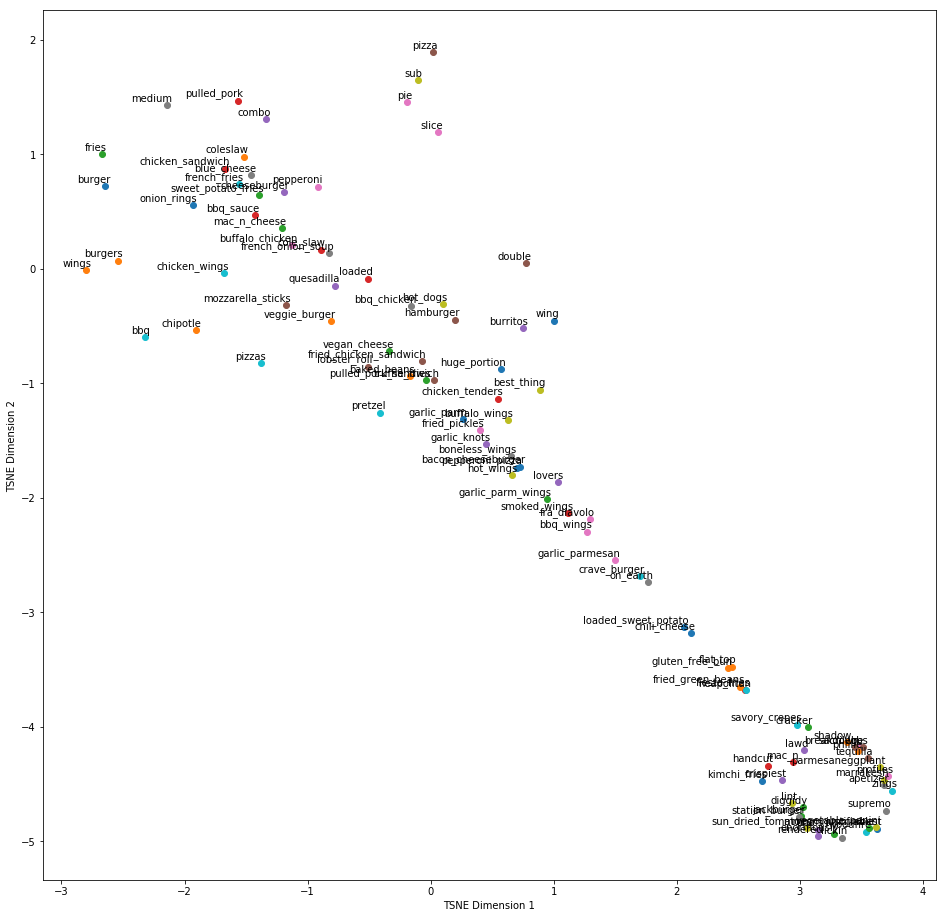

In [43]:
tsne_plot_words(models[5.0], n_words=n_words_on_plot, positive=positive, negative=negative)

Use keywords from a business to see word embedding vectors

In [44]:
search_results = get_restaurants('cuckoos')

['The Cuckoos Nest Albany']

In [45]:
n_words = 8
for restaurant in search_results:
    print(restaurant.biz_id)
    keywords = pd.DataFrame(restaurant.get_keywords())
    keywords.sort_values(by='score', ascending=False, inplace=True)
    for rating in sorted(keywords.star_rating.unique(),reverse=True):
        keywords_10 = list(keywords.word[keywords.star_rating==rating][0:10].values)
        try:
            print(rating,"rating",[w[0] for w in models[rating].wv.most_similar(
                positive=keywords_10, negative=negative, topn=n_words)])
        except:
            pass  
    print("\n")

The Cuckoos Nest Albany
5.0 rating ['verdile', 'an_abundance_of', 'merabec', 'morag', 'surf_n', 'eggplant_fries', "fisherman's", 'biriyani']
4.0 rating ['nacho_pie', 'orderesome', 'beef_brisket', 'my_companions', 'chicken_cacciatore', 'cheeseburger', 'chicken_teriyaki', 'fell_short']
3.0 rating ['dumplings', 'filet_mignon', 'edamame', 'spears', 'spicy_tuna', 'encrusted', 'small_portion', 'mussels']
2.0 rating ['killed', 'way_too_salty', 'latter', 'tastes_like', 'pita_bread', 'glorified', 'actual', 'lame']
1.0 rating ['every_bite', 'include', 'could_barely', "my_boyfriend's", 'muffin', 'tube', 'allergic', 'sauteed']




Restaurant Specific Model

In [46]:
word_embedding_models = {}

print("Restaurant Specific Model:", end=' ')
start = time.time()


#Loop through restaurants
for restaurant in restaurants:             
    #Fit a model to reviews for each restaurants reviews
    sentences = restaurant.get_review_sentences()
    model = Word2Vec(sentences,size=dim,window=5,min_count=1,workers=4)
    model.train(sentences,total_examples=models[rating].corpus_count,epochs=10)
        
    word_embedding_models[restaurant.biz_id] = model

end = time.time()
print(time.strftime('%H:%M:%S', time.gmtime(end-start)))

Restaurant Specific Model: 00:01:03


In [47]:
search_results = get_restaurants('cuckoos')

['The Cuckoos Nest Albany']

In [48]:
n_words = 8
n_words_on_plot = 100

for restaurant in search_results:
    print(restaurant.biz_id)
    keywords = pd.DataFrame(restaurant.get_keywords())
    keywords.sort_values(by='score', ascending=False, inplace=True)
    for rating in sorted(keywords.star_rating.unique(),reverse=True):
        keywords_10 = list(keywords.word[keywords.star_rating==rating][0:10].values)
        try:
            print(rating,"rating",[w[0] for w in word_embedding_models[restaurant.biz_id].wv.most_similar(
                positive=keywords_10, negative=negative, topn=n_words)])
        except:
            pass 
    print("\n")

The Cuckoos Nest Albany
5.0 rating ['meal', 'biscuit', 'time', 'a_bit', 'would', 'back', 'deviled_eggs', 'side']
4.0 rating ['biscuit', 'time', 'southern', 'perfect', 'deviled_eggs', 'would', 'sauce', 'hostess']
3.0 rating ['time', 'chicken', "cuckoo's_nest", 'deviled_eggs', 'thought', 'could', 'made', 'albany']
2.0 rating ['small', 'shrimp', 'dinner', 'came', "cuckoo's_nest", 'meal', 'chicken', 'perfect']
1.0 rating ['underneath', 'lovely', 'basket_of', 'however', 'option', 'beautiful', 'reasonable', 'beet']




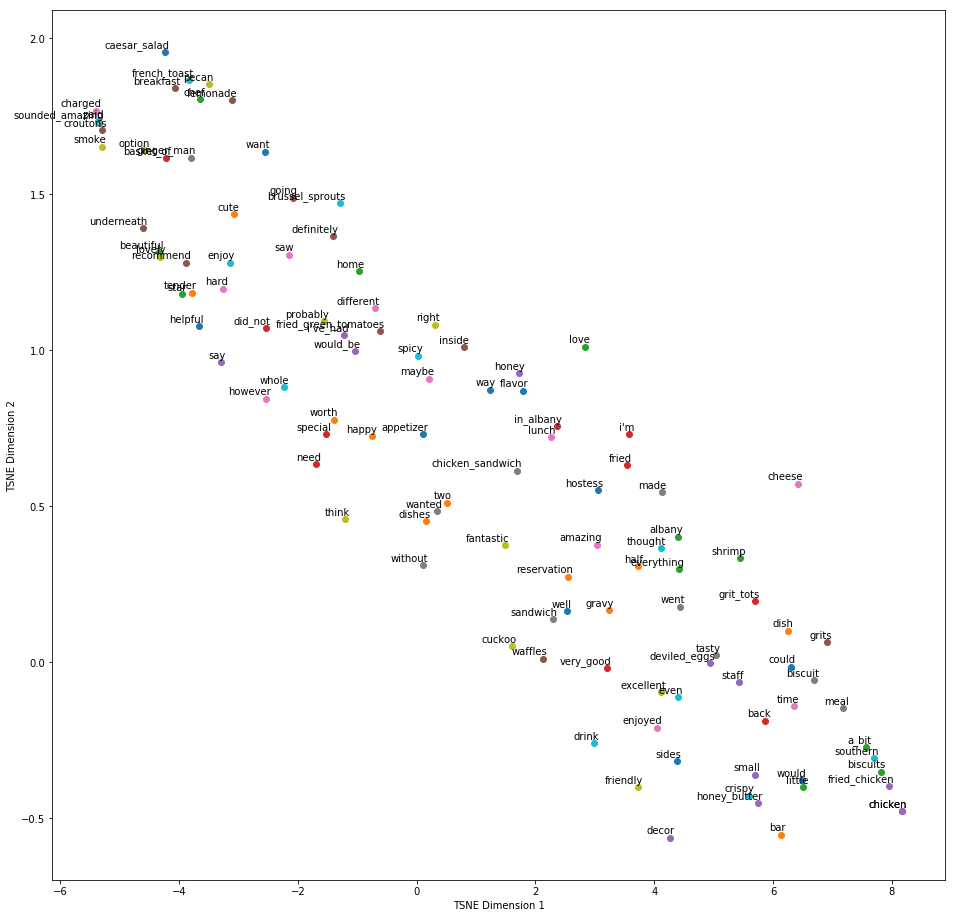

In [49]:
rest = search_results[0]
keywords = pd.DataFrame(rest.get_keywords()).sort_values(by='score', ascending=False)
positive = list(keywords.word[0:10].values)

tsne_plot_words(word_embedding_models[rest.biz_id], n_words=n_words_on_plot, positive=positive, negative=[])